<a href="https://colab.research.google.com/github/ashpakshaikh26732/CityScape-fcn-unet-unet-/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**all packages**

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

import tensorflow.keras.ops as K

from IPython.display import display,HTML

In [ ]:
!pip install tensorflow==2.18.0
!pip install tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html

import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU is running:", tpu.master())
except ValueError as e:
    print("TPU is not avaible:", e)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

/usr/local/lib/python3.11/dist-packages/jax/__init__.py:31: UserWarning: cloud_tpu_init failed: AttributeError("module 'libtpu' has no attribute 'get_library_path'")
 This a JAX bug; please report an issue at https://github.com/jax-ml/jax/issues
  _warn(f"cloud_tpu_init failed: {exc!r}\n This a JAX bug; please report "


TPU is running: 


In [ ]:
print(f'Number of TPUs: {strategy.num_replicas_in_sync}')

Number of TPUs: 8


**mixed precision training**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**copy datasets from drive**

In [ ]:
!cp /content/drive/MyDrive/cityscrap/Cityscapes/gtFine_trainvaltest.zip /content/
!cp /content/drive/MyDrive/cityscrap/Cityscapes/leftImg8bit_trainvaltest.zip /content

**extract trainig the data**

In [ ]:

os.system("unzip -q /content/gtFine_trainvaltest.zip -d /content/ ")
os.system("unzip -q /content/leftImg8bit_trainvaltest.zip -d /content/")

256

In [ ]:
print("Train Images:", len(os.listdir("/content/leftImg8bit/train/")))
print("Train Labels:", len(os.listdir("/content/gtFine/train/")))

Train Images: 18
Train Labels: 18


In [ ]:
print("test images : ", len(os.listdir('/content/leftImg8bit/test')))

test images :  6


**Global Valrible**

In [ ]:
img_height =640
img_width = 1280
batch_size = 1
final_batch_size = batch_size * strategy.num_replicas_in_sync


**loading images and labels from directry for training**

In [ ]:
def load_img():
    train_dir = '/content/leftImg8bit/train'
    train_image_cities = os.listdir(train_dir)
    train_images = []
    for city in sorted(train_image_cities):
        train_city = os.path.join(train_dir, city)
        images = sorted([os.path.join(train_city, img) for img in os.listdir(train_city) if img.endswith('.png')])
        train_images.extend(images)
    return train_images

def load_labels():
    train_dir = '/content/gtFine/train'
    train_labels_cities = os.listdir(train_dir)
    train_labels = []
    for city in sorted(train_labels_cities):
        train_city_label = os.path.join(train_dir, city)
        labels = sorted([os.path.join(train_city_label, f) for f in os.listdir(train_city_label) if f.endswith('_gtFine_labelIds.png')])
        train_labels.extend(labels)
    return train_labels

**reading images from path**

In [ ]:
def read_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

def read_labels(label_path):
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)
    label = tf.image.resize(label, (img_height, img_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.cast(label, tf.uint8)

**augmentation**

In [ ]:
def process_data(image_path, label_path):
    image = read_img(image_path)
    label = read_labels(label_path)
    return image, label

# def augment(image, label):
#     label = tf.cast(label, tf.float32)
#     if tf.random.uniform(()) > 0.5:
#         image = tf.image.flip_left_right(image)
#         label = tf.image.flip_left_right(label)
#     image = tf.image.random_brightness(image, max_delta=0.1)
#     label = tf.cast(label, tf.uint8)
#     return image, label



def augment(image, label):
    # Convert to float32 for image manipulations
    image = tf.cast(image, tf.float32)

    # Flip left-right
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)

    # Random hue
    image = tf.image.random_hue(image, max_delta=0.05)

    # Random cropping to the target resolution (e.g., 512x1024 or 768x1536)
    image, label = tf.image.resize_with_crop_or_pad(image, target_height=640, target_width=1280), tf.image.resize_with_crop_or_pad(label, target_height=640, target_width=1280)

    # Label should stay in uint8 after augmentation
    label = tf.cast(label, tf.uint8)

    return image, label


**creating dataset**

In [ ]:
def map_labels_tf(label):
    label = tf.squeeze(label, axis=-1)

    original_ids = tf.constant([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33], dtype=tf.int32)
    train_ids = tf.range(19, dtype=tf.int32)
    lookup = tf.fill([34], 255)
    lookup = tf.tensor_scatter_nd_update(lookup, tf.expand_dims(original_ids, axis=1), train_ids)
    y_mapped = tf.gather(lookup, tf.cast(label, tf.int32))
    return tf.expand_dims(y_mapped, axis=-1)

images = load_img()
labels = load_labels()
assert len(images) == len(labels), f"Mismatch: {len(images)} images, {len(labels)} labels"
print("Total Train Images:", len(images))
print("Total Train Labels:", len(labels))

def replace_ignore_label(image, label):
    label = tf.where(label == 255, 0, label)  # label is int32, so 255 and 0 are fine
    return image, label


train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
options = tf.data.Options()
options.experimental_deterministic = False  # Allow non-deterministic order for better performanxce
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA  # Shard data across TPU replicas

# Apply options to the dataset
train_dataset = train_dataset.with_options(options)

train_dataset = train_dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset =train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda image, label: (image, map_labels_tf(label)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(replace_ignore_label, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=100).cache().batch(final_batch_size,drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = strategy.experimental_distribute_dataset(train_dataset)

Total Train Images: 2975
Total Train Labels: 2975


**loading images and labels from directry for validiation**

In [ ]:
def load_img_val():
    train_dir = '/content/leftImg8bit/val'
    train_image_cities = os.listdir(train_dir)
    train_images = []

    for city in sorted(train_image_cities):
        train_city = os.path.join(train_dir, city)
        images = sorted([os.path.join(train_city, img) for img in os.listdir(train_city) if img.endswith('.png')])
        train_images.extend(images)

    return train_images

def load_labels_val():
    train_dir = '/content/gtFine/val'
    train_labels_cities = os.listdir(train_dir)
    train_labels = []
    for city in sorted(train_labels_cities):
        train_city_label = os.path.join(train_dir, city)
        labels = sorted([os.path.join(train_city_label, f) for f in os.listdir(train_city_label) if f.endswith('_gtFine_labelIds.png')])
        train_labels.extend(labels)
    return train_labels

In [ ]:
def read_img_val(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

def read_labels_val(label_path):
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)
    label = tf.image.resize(label, (img_height, img_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.cast(label, tf.uint8)

In [ ]:
def process_data_val(image_path, label_path):
    image = read_img(image_path)
    label = read_labels(label_path)
    return image, label

def map_labels_tf(label):
    label = tf.squeeze(label, axis=-1)

    original_ids = tf.constant([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33], dtype=tf.int32)
    train_ids = tf.range(19, dtype=tf.int32)
    lookup = tf.fill([34], 255)
    lookup = tf.tensor_scatter_nd_update(lookup, tf.expand_dims(original_ids, axis=1), train_ids)
    y_mapped = tf.gather(lookup, tf.cast(label, tf.int32))
    return tf.expand_dims(y_mapped, axis=-1)

images = load_img_val()
labels = load_labels_val()
assert len(images) == len(labels), f"Mismatch: {len(images)} images, {len(labels)} labels"
print("Total Train Images:", len(images))
print("Total Train Labels:", len(labels))

def replace_ignore_label(image, label):
    label = tf.where(label == 255, 0, label)  # label is int32, so 255 and 0 are fine
    return image, label


val_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
options = tf.data.Options()
options.experimental_deterministic = False  # Allow non-deterministic order for better performance
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA  # Shard data across TPU replicas

# Apply options to the dataset
val_dataset = val_dataset.with_options(options)

val_dataset = val_dataset.map(process_data_val, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.map(lambda image, label: (image, map_labels_tf(label)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(replace_ignore_label, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=100).cache().batch(16,drop_remainder=True)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = strategy.experimental_distribute_dataset(val_dataset)

Total Train Images: 500
Total Train Labels: 500


**loading images and labels from directry for testing**

In [ ]:
def load_img_test():
    train_dir = '/content/leftImg8bit/test'
    train_image_cities = os.listdir(train_dir)
    train_images = []

    for city in sorted(train_image_cities):
        train_city = os.path.join(train_dir, city)
        images = sorted([os.path.join(train_city, img) for img in os.listdir(train_city) if img.endswith('.png')])
        train_images.extend(images)

    return train_images

def load_labels_test():
    train_dir = '/content/gtFine/test'
    train_labels_cities = os.listdir(train_dir)
    train_labels = []
    for city in sorted(train_labels_cities):
        train_city_label = os.path.join(train_dir, city)
        labels = sorted([os.path.join(train_city_label, f) for f in os.listdir(train_city_label) if f.endswith('_gtFine_labelIds.png')])
        train_labels.extend(labels)
    return train_labels

In [ ]:
def read_img_test(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = img / 255.0
    return img

def read_labels_test(label_path):
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)
    label = tf.image.resize(label, (img_height, img_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.cast(label, tf.uint8)

In [ ]:
def process_data_val(image_path, label_path):
    image = read_img(image_path)
    label = read_labels(label_path)
    return image, label

def map_labels_tf(label):
    label = tf.squeeze(label, axis=-1)
    original_ids = tf.constant([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33], dtype=tf.int32)
    train_ids = tf.range(19, dtype=tf.int32)
    lookup = tf.fill([34], 255)
    lookup = tf.tensor_scatter_nd_update(lookup, tf.expand_dims(original_ids, axis=1), train_ids)
    y_mapped = tf.gather(lookup, tf.cast(label, tf.int32))
    return tf.expand_dims(y_mapped, axis=-1)


images = load_img_val()
labels = load_labels_val()

# Create TF Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
test_dataset = test_dataset.map(process_data_val, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda image, label: (image, map_labels_tf(label)), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=1000).cache().batch(final_batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = strategy.experimental_distribute_dataset(test_dataset)

**UNET**

In [ ]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters, block_name, kernel_size=3, strides=(1,1), activation='relu'):
        super().__init__(name=block_name)
        self.conv1 = tf.keras.layers.Conv2D(n_filters, kernel_size, strides=strides,
                                           padding='same', activation=activation,
                                           name=f"{block_name}_conv1")
        self.conv2 = tf.keras.layers.Conv2D(n_filters, kernel_size, strides=strides,
                                           padding='same', activation=activation,
                                           name=f"{block_name}_conv2")

    def call(self, inputs):
        x = self.conv1(inputs)
        return self.conv2(x)


In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters, pool_size, dropout_rate, block_name):
        super().__init__(name=block_name)
        self.conv_block = ConvBlock(n_filters, block_name)
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs):
        conv_output = self.conv_block(inputs)
        pooled_output = self.pool(conv_output)
        dropped_output = self.dropout(pooled_output)
        return conv_output, dropped_output

In [ ]:
class Encoder(tf.keras.models.Model):
    def __init__(self, input_shape=(640,1280,3)):
        super().__init__(name='encoder')
        base = tf.keras.applications.ResNet50(
            include_top=False, weights='imagenet', input_shape=input_shape)
        layer_names = [
            'conv1_relu',          # 512 -> 256
            'conv2_block3_out',    # 256 -> 128
            'conv3_block4_out',    # 128 -> 64
            'conv4_block6_out',    # 64  -> 32
        ]
        outputs = [base.get_layer(name).output for name in layer_names]
        self.feature_extractor = tf.keras.Model(base.input, outputs)
        self.backbone = base  # for final bottleneck

    def call(self, inputs):
        f1, f2, f3, f4 = self.feature_extractor(inputs)
        bottleneck = self.backbone(inputs)  # 32 -> 16
        return bottleneck, (f1, f2, f3, f4)

In [ ]:
class BottleNeck(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__(name='bottle_neck')
        self.reduce = tf.keras.layers.Conv2D(1024, (1,1), padding='same', name='bottleneck_reduce')
        self.block = ConvBlock(1024, 'bottleneck')

    def call(self, x):
        x = self.reduce(x)
        return self.block(x)

In [ ]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters, dropout_rate, block_name):
        super().__init__(name=block_name)
        self.up = tf.keras.layers.Conv2DTranspose(n_filters, (3,3), strides=(2,2),
                                                 padding='same', name=f"{block_name}_up")
        self.concat = tf.keras.layers.Concatenate(name=f"{block_name}_concat")
        self.dropout = tf.keras.layers.Dropout(dropout_rate, name=f"{block_name}_dropout")
        self.conv_block = ConvBlock(n_filters, block_name)

    def call(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            x = self.concat([x, skip])
        x = self.dropout(x)
        return self.conv_block(x)

In [ ]:
class Decoder(tf.keras.models.Model):
    def __init__(self, n_classes=19):
        super().__init__(name='decoder')
        self.dec1 = DecoderBlock(1024, 0.3, 'dec1')
        self.dec2 = DecoderBlock(512,  0.3, 'dec2')
        self.dec3 = DecoderBlock(256,  0.3, 'dec3')
        self.dec4 = DecoderBlock(64,   0.3, 'dec4')
        self.dec5 = DecoderBlock(32,   0.3, 'dec5')
        self.final_conv = tf.keras.layers.Conv2D(n_classes, (1,1), padding='same',
                                               name='final_conv')

    def call(self, x, skips):
        f1, f2, f3, f4 = skips
        x = self.dec1(x, f4)
        x = self.dec2(x, f3)
        x = self.dec3(x, f2)
        x = self.dec4(x, f1)
        x = self.dec5(x)
        return self.final_conv(x)

In [ ]:


class Unet(tf.keras.models.Model):
    def __init__(self, input_shape=(640,1280,3), n_classes=19):
        super().__init__(name='unet_resnet50')
        self.encoder = Encoder(input_shape)
        self.bottleneck = BottleNeck()
        self.decoder = Decoder(n_classes)
        self.softmax = tf.keras.layers.Softmax(axis=-1, name='softmax')

    def call(self, inputs):
        bottleneck_feat, skips = self.encoder(inputs)
        x = self.bottleneck(bottleneck_feat)
        x = self.decoder(x, skips)
        return self.softmax(x)

# with strategy.scope():
#   unet = Unet(input_shape=(640,1280,3), n_classes=19)
#   unet.build((None,640,1280,3))
#   unet.summary()


In [ ]:
with strategy.scope():
  unet = Unet()
  sample_input = tf.random.uniform((1, 640, 1280, 3))
  unet(sample_input)  # Builds the model
  print("Model built:", unet.built)
  print("Trainable variables:", [var.name for var in unet.trainable_variables])

# unet = Unet()
# sample_input = tf.random.uniform((1, 640, 1280, 3))
# unet(sample_input)  # Builds the model
# print("Model built:", unet.built)
# print("Trainable variables:", [var.name for var in unet.trainable_variables])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'dec5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model built: True
Trainable variables: ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta

**defining loss**

In [ ]:


class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, name="DiceLoss"):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE, name=name)
        self.smooth = smooth

    def compute_per_sample(self, y_true, y_pred):
        dtype = y_pred.dtype

        # one-hot encode
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=19, dtype=dtype)

        # valid mask
        mask = tf.not_equal(y_true, 255)
        mask = tf.cast(mask, dtype)[..., tf.newaxis]  # add channel dimension

        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # intersection and union
        intersection = tf.reduce_sum(y_true_one_hot * y_pred * mask, axis=[1,2])
        union = tf.reduce_sum(y_true_one_hot * mask, axis=[1,2]) + tf.reduce_sum(y_pred * mask, axis=[1,2])

        dice_per_class = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss_per_sample = 1.0 - tf.reduce_mean(dice_per_class, axis=-1)  # (batch,)

        return dice_loss_per_sample

    def call(self, y_true, y_pred):
        # fallback for model.fit()
        return tf.reduce_mean(self.compute_per_sample(y_true, y_pred))



class SemanticSegmentationLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, beta=1.0, name="SemanticSegmentationLoss"):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE, name=name)
        self.alpha = alpha
        self.beta = beta
        self.dice_loss = DiceLoss()
        self.class_weights = tf.constant([
            0.1, 0.2, 0.5, 0.7, 0.8,
            1.0, 1.2, 1.3, 0.6, 0.9,
            0.4, 1.5, 1.6, 1.1, 1.7,
            1.8, 1.9, 2.0, 2.1
        ], dtype=tf.float32)
        self.ce_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction='none'
        )

    def compute_per_sample(self, y_true, y_pred):
        dtype = y_pred.dtype

        # squeeze labels
        y_true = tf.squeeze(y_true, axis=-1)

        # mask invalid pixels (label 255)
        mask_bool = tf.not_equal(y_true, 255)
        mask = tf.cast(mask_bool, dtype)

        # one-hot encode labels
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=19, dtype=dtype)

        # cross-entropy loss per pixel
        ce = self.ce_loss_fn(y_true, y_pred)  # (batch, height, width)
        ce = tf.cast(ce, dtype)

        # weighted cross-entropy
        class_weights = tf.cast(self.class_weights, dtype)
        pixel_weights = tf.tensordot(y_true_one_hot, class_weights, axes=([-1], [0]))
        ce_weighted = ce * pixel_weights * mask

        # per-sample (batch) CE loss
        sum_ce = tf.reduce_sum(ce_weighted, axis=[1,2])
        count_px = tf.reduce_sum(mask, axis=[1,2])
        ce_per_sample = sum_ce / tf.maximum(count_px, 1e-6)

        # dice loss per sample
        dice_per_sample = self.dice_loss.compute_per_sample(y_true, y_pred)

        # combined weighted loss
        total_loss_per_sample = self.alpha * ce_per_sample + self.beta * dice_per_sample
        return total_loss_per_sample  # (batch,)

    def call(self, y_true, y_pred):
        # fallback for model.fit()
        return tf.reduce_mean(self.compute_per_sample(y_true, y_pred))


**IOU metric**

In [ ]:
class IOUMetric(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, name="iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = 1e-6
        self.sum_intersection = self.add_weight(name="sum_intersection", shape=(n_classes,), initializer="zeros")
        self.sum_union = self.add_weight(name="sum_union", shape=(n_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):


        y_pred = tf.argmax(y_pred, axis=-1)

        # Fix here ➡️  mask 255
        valid_mask = tf.not_equal(y_true, 255)




        y_true = tf.boolean_mask(y_true, valid_mask)
        y_pred = tf.boolean_mask(y_pred, valid_mask)

        cm = tf.math.confusion_matrix(
            tf.reshape(y_true, [-1]),
            tf.reshape(y_pred, [-1]),
            num_classes=self.n_classes,
            dtype=tf.float32
        )

        intersection = tf.linalg.diag_part(cm)
        union = tf.reduce_sum(cm, axis=0) + tf.reduce_sum(cm, axis=1) - tf.linalg.diag_part(cm)

        self.sum_intersection.assign_add(intersection)
        self.sum_union.assign_add(union)




    def result(self):
        iou = (self.sum_intersection + self.smooth) / (self.sum_union + self.smooth)
        mean_iou = tf.reduce_mean(iou)
        return mean_iou

    def reset_state(self):
        self.sum_intersection.assign(tf.zeros_like(self.sum_intersection))
        self.sum_union.assign(tf.zeros_like(self.sum_union))


**per class IOU metrics**

In [ ]:
class PerClassIOUMetric(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, name="iou_per_class", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = 1e-6
        self.sum_intersection = self.add_weight(name="sum_intersection", shape=(n_classes,), initializer="zeros")
        self.sum_union = self.add_weight(name="sum_union", shape=(n_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.n_classes)
        y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=self.n_classes)

        intersection = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=[0, 1,2])
        union = tf.reduce_sum(y_true_one_hot, axis=[0, 1,2]) + tf.reduce_sum(y_pred_one_hot, axis=[0, 1,2]) - intersection

        self.sum_intersection.assign_add(intersection)
        self.sum_union.assign_add(union)


    def result(self):
        return (self.sum_intersection + self.smooth) / (self.sum_union + self.smooth)

    def reset_state(self):
        self.sum_intersection.assign(tf.zeros_like(self.sum_intersection))
        self.sum_union.assign(tf.zeros_like(self.sum_union))


**Dice Coeficient Metrics**

In [ ]:
class Dice_Coefficent_matrics(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, name='dice_coefficient', **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = 1e-6
        self.total_dice = self.add_weight(name="total_dice", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.n_classes)
        y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=self.n_classes)

        intersection = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=[1, 2])
        total = tf.reduce_sum(y_true_one_hot, axis=[1, 2]) + tf.reduce_sum(y_pred_one_hot, axis=[1, 2])

        dice = (2.0 * intersection + self.smooth) / (total + self.smooth)
        mean_dice = tf.reduce_mean(dice)

        self.total_dice.assign_add(mean_dice)
        self.count.assign_add(1.0)

    def result(self):
        return self.total_dice / tf.maximum(self.count, 1.0)

    def reset_state(self):
        self.total_dice.assign(0.0)
        self.count.assign(0.0)


**per class_dice_coefficent metrics**

In [ ]:


class PerClassDiceCoefficientMatrics(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, name="dice_per_class", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = 1e-6
        self.sum_intersection = self.add_weight(name="sum_intersection", shape=(n_classes,), initializer="zeros")
        self.sum_union = self.add_weight(name="sum_union", shape=(n_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.squeeze(y_true, axis=-1)  # This line is commented, but it might be useful if needed
        y_pred = tf.argmax(y_pred, axis=-1)

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.n_classes)
        y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=self.n_classes)

        intersection = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=[0, 1, 2])
        total = tf.reduce_sum(y_true_one_hot, axis=[0, 1, 2]) + tf.reduce_sum(y_pred_one_hot, axis=[0, 1, 2])

        self.sum_intersection.assign_add(intersection)
        self.sum_union.assign_add(total)

    def result(self):
        return (2.0 * self.sum_intersection + self.smooth) / (self.sum_union + self.smooth)

    def reset_state(self):
        self.sum_intersection.assign(tf.zeros_like(self.sum_intersection))
        self.sum_union.assign(tf.zeros_like(self.sum_union))


**Pixel Accurcy Metrics**

In [ ]:
class Pixel_accurcy_metrics(tf.keras.metrics.Metric):
    def __init__(self, n_classes = 19,name="pixel_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name="correct", initializer="zeros")
        self.total = self.add_weight(name="total", initializer="zeros")
        self.n_classes = n_classes
    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1),tf.int32)

        correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
        total = tf.size(y_true)

        self.correct.assign_add(correct)
        self.total.assign_add(total)

    def result(self):
        return self.correct / tf.maximum(self.total, 1.0)

    def reset_state(self):
        self.correct.assign(0)
        self.total.assign(0)


In [ ]:
batch_size = 16
height = 512
width = 512
num_classes = 19

y_true = tf.random.uniform((batch_size, height, width), minval=0, maxval=num_classes, dtype=tf.int32)
y_true = tf.where(tf.random.uniform((batch_size, height, width)) > 0.9, 255, y_true)

y_pred = tf.random.uniform((batch_size, height, width, num_classes), minval=0, maxval=1, dtype=tf.float32)
y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1, keepdims=True)  # Softmax-like normalization

# Initialize metrics
mean_iou = IOUMetric(n_classes=num_classes)
per_class_iou = PerClassIOUMetric(n_classes=num_classes)
mean_dice = Dice_Coefficent_matrics(n_classes=num_classes)
per_class_dice = PerClassDiceCoefficientMatrics(n_classes=num_classes)
pixel_acc = Pixel_accurcy_metrics(n_classes=num_classes)

# Update states
mean_iou.update_state(y_true, y_pred)
per_class_iou.update_state(y_true, y_pred)
mean_dice.update_state(y_true, y_pred)
per_class_dice.update_state(y_true, y_pred)  # Note: Bug here, should be y_true, y_pred
pixel_acc.update_state(y_true, y_pred)

# Get results
print(f"Mean IoU: {mean_iou.result().numpy()}")
print(f"Per-class IoU: {per_class_iou.result().numpy()}")
print(f"Mean Dice: {mean_dice.result().numpy()}")
print(f"Per-class Dice: {per_class_dice.result().numpy()}")
print(f"Pixel Accuracy: {pixel_acc.result().numpy()}")

# Reset states (just to show it works)
mean_iou.reset_state()
per_class_iou.reset_state()
mean_dice.reset_state()
per_class_dice.reset_state()
pixel_acc.reset_state()


Mean IoU: 0.027087116613984108
Per-class IoU: [0.02540723 0.02566853 0.02603719 0.02533535 0.02505811 0.02556249
 0.02525262 0.02590027 0.02574645 0.02535807 0.025767   0.02577571
 0.02565019 0.02540168 0.02565813 0.0261505  0.02611198 0.02582592
 0.02515401]
Mean Dice: 0.04996311664581299
Per-class Dice: [0.0495554  0.05005229 0.05075292 0.04941867 0.0488911  0.04985067
 0.04926127 0.05049277 0.05020041 0.04946188 0.05023947 0.05025604
 0.05001742 0.04954483 0.05003253 0.05096816 0.05089499 0.05035146
 0.04907361]
Pixel Accuracy: 0.047461509704589844


**optimizer**

In [ ]:
with strategy.scope():
    optimizer_fcn =tf.optimizers.AdamW(learning_rate=5e-6, weight_decay=1e-5)


    optimizer_unet = tf.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)
    optimizer_unet_plus_plus =  tf.optimizers.AdamW(learning_rate=5e-4, weight_decay=1e-5)




**checkPoint dirs**

In [ ]:
checkpoint_dir_fcn = '/content/drive/MyDrive/CityScapes_model_checkpoints/fcn'
checkpoint_dir_unet = '/content/drive/MyDrive/CityScapes_model_checkpoints_new/unet'
checkpoint_dir_unet_plus_plus = '/content/drive/MyDrive/CityScapes_model_checkpoints/unet_plus_plus_new'
fcn_log_dir = '/content/drive/MyDrive/CityScapes_model_checkpoints/fcn_log_dir'
unet_log_dir = '/content/drive/MyDrive/CityScapes_model_checkpoints_new/unet_log_dir'
unet_plus_plus_log_dir = '/content/drive/MyDrive/CityScapes_model_checkpoints/unet_plus_plus_new_log_dir'

**custom callbacks**

In [ ]:
# class Custom_checkpoint_Callabck(tf.keras.callbacks.Callback):
#   def __init__(self, checkpoint_dir_fcn , checkpoint_dir_unet , checkpoint_dir_unet_plus_plus , fcn , unet , unet_plus_plus , optimizer_fcn ,optimizer_unet ,optimizer_unet_plus_plus  ) :
#     super().__init__()
#     self.checkpoint_dir_fcn = checkpoint_dir_fcn
#     self.checkpoint_dir_unet = checkpoint_dir_unet
#     self.checkpoint_dir_unet_plus_plus = checkpoint_dir_unet_plus_plus
#     self.checkpoint_fcn = tf.train.Checkpoint(
#         model = fcn ,
#         optimizer = optimizer_fcn,
#         epoch = tf.Variable(0 , dtype = tf.int64)
#     )
#     self.checkpoint_manager_for_fcn = tf.train.CheckpointManager(
#         self.checkpoint_fcn ,
#         self.checkpoint_dir_fcn ,
#         max_to_keep=3
#     )
#     self.checkpoint_unet = tf.train.Checkpoint(
#         model = unet ,
#         optimizer = optimizer_unet,
#         epoch = tf.Variable(0 , dtype = tf.int64)
#     )
#     self.checkpoint_manager_for_unet = tf.train.CheckpointManager(
#         self.checkpoint_unet ,
#         self.checkpoint_dir_unet ,
#         max_to_keep=3
#     )
#     self.checkpoint_unet_plus_plus = tf.train.Checkpoint(
#         model = unet_plus_plus ,
#         optimizer = optimizer_unet_plus_plus,
#         epoch = tf.Variable(0 , dtype = tf.int64)
#     )
#     self.checkpoint_manager_for_unet_plus_plus = tf.train.CheckpointManager(
#         self.checkpoint_unet_plus_plus ,
#         self.checkpoint_dir_unet_plus_plus ,
#         max_to_keep=3
#     )
#   def on_epoch_end(self , epoch, logs = None):
#     self.checkpoint_fcn.epoch.assign(epoch+1)
#     self.checkpoint_manager_for_fcn.save()
#     print(f"\nCheckpoint saved for epoch {epoch } at {self.checkpoint_manager_for_fcn.latest_checkpoint} for fcn model")
#     self.checkpoint_unet.epoch.assign(epoch+1)
#     self.checkpoint_manager_for_unet.save()
#     print(f"\nCheckpoint saved for epoch {epoch } at {self.checkpoint_manager_for_unet.latest_checkpoint} for unet model")
#     self.checkpoint_unet_plus_plus.epoch.assign(epoch+1)
#     self.checkpoint_manager_for_unet_plus_plus.save()
#     print(f"\nCheckpoint saved for epoch {epoch } at {self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint} for unet_plus_plus model")
#   def load_latest_model(self):
#     if self.checkpoint_manager_for_fcn.latest_checkpoint and self.checkpoint_manager_for_unet.latest_checkpoint and self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint :

#       self.checkpoint_fcn.restore(self.checkpoint_manager_for_fcn.latest_checkpoint)
#       self.checkpoint_unet.restore(self.checkpoint_manager_for_unet.latest_checkpoint)
#       self.checkpoint_unet_plus_plus.restore(self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint)
#       start_epoch =self.checkpoint_fcn.epoch.numpy()
#       print(f"Restored from checkpoint: {self.checkpoint_manager_for_fcn.latest_checkpoint}, "
#                   f"resuming from epoch {start_epoch}")
#       print(f"Restored from checkpoint: {self.checkpoint_manager_for_unet.latest_checkpoint}, "
#                   f"resuming from epoch {start_epoch}")
#       print(f"Restored from checkpoint: {self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint}, "
#                   f"resuming from epoch {start_epoch}")
#       return start_epoch
#     else :
#       print('no checkpoint found starting from epoch 1')
#       return 1


class Custom_checkpoint_Callabck(tf.keras.callbacks.Callback):
  def __init__(self,checkpoint_dir , model , optimizer):
    super().__init__()
    self.checkpoint_dir = checkpoint_dir
    self._model = model

    self.checkpoint = tf.train.Checkpoint(
        model = self._model ,
        optimizer = optimizer ,
        epoch = tf.Variable(1 , dtype = tf.int64)
    )

    self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,directory=self.checkpoint_dir , max_to_keep=5)
    os.makedirs(self.checkpoint_dir, exist_ok=True)
  def on_epoch_end(self, epoch , logs = None):
    self.checkpoint.epoch.assign(epoch)
    self.checkpoint_manager.save()
    print(f"\nCheckpoint saved for epoch {epoch } at {self.checkpoint_manager.latest_checkpoint} for {self._model} model")

  def load_latest_model(self):
    if self.checkpoint_manager.latest_checkpoint :
      self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint).assert_existing_objects_matched()
      start_epoch =self.checkpoint.epoch.numpy()
      print(f"Restored from checkpoint: {self.checkpoint_manager.latest_checkpoint}, resuming from epoch {start_epoch}")
      return start_epoch
    else :
      print('no checkpoint found starting from epoch 1')
      return 1


In [ ]:
# class Custom_early_stopping_callback(tf.keras.callbacks.Callback):
#   def __init__(self, paticance = 15  , min_delta = 1e-4):
#     self.patiance = paticance
#     self.min_delta = min_delta
#     self.best_loss = {
#         'fcn' : float('inf') ,
#         'unet' : float('inf') ,
#         'unet_plus_plus' : float('inf')
#     }
#     self.stoped_epoch = 0
#     self.wait = {
#         'fcn' : 0 ,
#         'unet': 0 ,
#         'unet_plus_plus' : 0
#     }
#   def early_stoping(self, epoch , val_loss):
#     if (val_loss['fcn']< self.best_loss['fcn']-self.min_delta):
#       self.best_loss['fcn'] = val_loss['fcn']
#       self.wait['fcn'] = 0
#     else :
#       self.wait['fcn'] +=1
#     if (val_loss['unet']< self.best_loss['unet']-self.min_delta):
#       self.best_loss['unet'] = val_loss['unet']
#       self.wait['unet'] = 0
#     else  :
#       self.wait['unet']+=1
#     if (val_loss['unet_plus_plus']< self.best_loss['unet_plus_plus']-self.min_delta):
#       self.best_loss['unet_plus_plus'] = val_loss['unet_plus_plus']
#       self.wait['unet_plus_plus'] = 0
#     else :
#       self.wait['unet_plus_plus']+=1
#     if self.wait['fcn'] > self.patiance and self.wait['unet']>self.patiance and self.wait['unet_plus_plus']>self.patiance:
#       self.stoped_epoch  =epoch
#       print (f'early stoping trainig at {self.stoped_epoch}')
#       return True
#     return False


class Custom_early_stopping_callback(tf.keras.callbacks.Callback):
  def __init__(self, paticance = 15 , min_delta=1e-4):
    super().__init__()
    self.paticance=paticance
    self.min_delta = min_delta
    self.best_loss = float('inf')
    self.stoped_epoch = 0
    self.wait = 0


  def early_stoping(self, epoch , val_loss):
    if val_loss < self.best_loss-self.min_delta :
      self.best_loss = val_loss
      self.wait = 0

    else :
      self.wait +=1
    if self.wait > self.paticance  :
      self.stoped_epoch  =epoch
      print (f'early stoping trainig at {self.stoped_epoch}')
      return True
    return False


In [ ]:
# class Custom_learning_rate_schedule(tf.keras.callbacks.Callback):
#   def __init__(self , optimizer_fcn , optimizer_unet , optimizer_unet_plus_plus , factor = 0.5 , patiance = 5 , min_delta = 1e-4 , min_lr = 1e-8 ):
#     super().__init__()
#     self.factor = factor
#     self.patiance = patiance
#     self.min_delta = min_delta
#     self.min_lr = min_lr
#     self.best_val_loss = {
#         'fcn' : float('inf') ,
#         'unet': float('inf') ,
#         'unet_plus_plus' : float('inf')
#     }
#     self.optimzer  = {
#         'fcn' : optimizer_fcn ,
#         'unet' : optimizer_fcn ,
#         'unet_plus_plus': optimizer_unet_plus_plus
#     }
#     self.wait = {
#         'fcn' : 0 ,
#         'unet': 0 ,
#         'unet_plus_plus' : 0
#     }
#   def change_learning_rate(self, epoch , val_loss):
#     for model_name , val_loss in val_loss.items():
#       if val_loss < self.best_val_loss[model_name]-self.min_delta:
#         self.best_val_loss[model_name] = val_loss
#         self.wait[model_name] = 0
#       else :
#         self.wait[model_name] +=1
#       if self.wait[model_name] >= self.patiance :
#         old_lr = self.optimzer[model_name].lr.numpy()
#         new_lr = tf.maximum(old_lr*self.factor , self.min_lr)
#         self.optimzer[model_name].lr.assign(new_lr)
#         print (f'learning rate for model : {model_name} has been change from : {old_lr} to the new lr : {new_lr} at epoch : {epoch}')
#         self.wait= 0

class Custom_learning_rate_schedule(tf.keras.callbacks.Callback):
  def __init__(self, optimizer , factor = 0.5 , min_delta = 1e-3,paticance = 3 , min_lr = 1e-13):
    super().__init__()
    self.optimizer = optimizer
    self.factor = factor
    self.patiance = paticance
    self.min_lr= min_lr
    self.min_delta = min_delta
    self.best_loss = float('inf')
    self.wait = 0

  def change_learning_rate(self, epoch , val_loss) :
    if val_loss < self.best_loss-self.min_delta :
      self.best_loss = val_loss
      self.wait = 0
    else :
      self.wait +=1
    if self.wait > self.patiance :
      old_lr = self.optimizer.learning_rate.numpy()
      new_lr = tf.maximum(old_lr*self.factor , self.min_lr)
      self.optimizer.learning_rate.assign(new_lr)
      print (f'learning rate for model  has been change from : {old_lr} to the new lr : {new_lr} at epoch : {epoch}')
      self.wait = 0


In [ ]:
# class Custom_Training_logger_callback(tf.keras.callbacks.Callback):
#   def __init__(self, batches_per_epoch):
#     super().__init__()
#     self.model_name = ['fcn' , 'unet' , 'unet_plus_plus']
#     self.batch_per_epoch = batches_per_epoch
#     self.batch_table_display = None
#     self.graph_display = None
#   def On_epoch_begin(self, epoch ):
#     print(f'Epoch begins : {epoch}')
#     self.progress_bar = tqdm(total=self.batch_per_epoch,desc=f'epoch {epoch}')
#     self.batch_table_data = []
#     self.batch_loss = {
#         'fcn':[] ,
#         'unet': [] ,
#         'unet_plus_plus' :[]
#     }

#     self.epoch_table_data = []
#     display(HTML('<h3>📊 Batch-wise Loss Table</h3>'))


#   def on_batch_end(self, batch , epoch,data = None):
#     self.progress_bar.set_postfix({
#         f'epoch :{epoch} , batch ': batch / self.batch_per_epoch
#         })
#     self.progress_bar.update(1)
#     if data == None :
#       return
#     self.batch_table_data.append({
#         'batch': batch ,
#         'fcn_loss' : data['fcn']['loss'] ,

#         'unet_loss' :data['unet']['loss'],

#         'unet_plus_plus_loss' : data['unet_plus_plus']['loss']  ,

#         'fcn_IOUMetric' : data['fcn']['metrics']['IOUMetric'] ,
#         'fcn_PerClassIOUMetric' : data['fcn']['metrics']['PerClassIOUMetric'],
#         'fcn_Dice_Coefficent_matrics' :  data['fcn']['metrics']['Dice_Coefficent_matrics'],
#         'fcn_PerClassDiceCoefficientMatrics' : data['fcn']['metrics']['PerClassDiceCoefficientMatrics'],
#         'fcn_Pixel_accurcy_metrics' : data['fcn']['metrics']['Pixel_accurcy_metrics'],
#         'unet_IOUMetric' : data['unet']['metrics']['IOUMetric'] ,
#         'unet_PerClassIOUMetric' : data['unet']['metrics']['PerClassIOUMetric'],
#         'unet_Dice_Coefficent_matrics' :  data['unet']['metrics']['Dice_Coefficent_matrics'],
#         'unet_PerClassDiceCoefficientMatrics' : data['unet']['metrics']['PerClassDiceCoefficientMatrics'],
#         'unet_Pixel_accurcy_metrics' : data['unet']['metrics']['Pixel_accurcy_metrics'],
#         'unet_plus_plus_IOUMetric' : data['unet_plus_plus']['metrics']['IOUMetric'] ,
#         'unet_plus_plus_PerClassIOUMetric' : data['unet_plus_plus']['metrics']['PerClassIOUMetric'],
#         'unet_plus_plus_Dice_Coefficent_matrics' :  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics'],
#         'unet_plus_plus_PerClassDiceCoefficientMatrics' : data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics'],
#         'unet_plus_plus_Pixel_accurcy_metrics' : data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics'],

#       })


#     df = pd.DataFrame(self.batch_table_data)

#     if self.batch_table_display is None:
#       self.batch_table_display = display( df, display_id=True)
#     else :
#       self.batch_table_display.update(df)
#     self.batch_loss['fcn'].append(data['fcn']['loss'])
#     self.batch_loss['unet'].append(data['unet']['loss'])
#     self.batch_loss['unet_plus_plus'].append(data['unet_plus_plus']['loss'])

#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#     axes[0].plot(self.batch_loss['fcn'], label='FCN Loss', marker='o')
#     axes[0].plot(self.batch_loss['unet'], label='U-Net Loss', marker='o')
#     axes[0].plot(self.batch_loss['unet_plus_plus'], label='U-Net++ Loss', marker='o')
#     axes[0].set_title('Training Loss')
#     axes[0].set_xlabel('Batch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True)



#     plt.tight_layout()
#     if self.graph_display is None:
#       display(HTML('<h3>📉 Loss Graphs (Batch-wise Trend)</h3>'))
#       self.graph_display = display(fig, display_id=True)
#     else:
#       self.graph_display.update(fig)
#     plt.close(fig)


#   def on_epoch_end(self , epoch ,data):
#     self.progress_bar.close()
#     if data == None :
#       return
#     display(HTML('<h3>📊 Epoch Summary Table</h3>'))
#     self.epoch_table_data.append({
#         'epoch': epoch ,
#         'fcn_loss' : data['fcn']['loss'] ,
#         'fcn_val_loss':data['fcn']['val_loss'] ,
#         'unet_loss' :data['unet']['loss'],
#         'unet_val_loss' : data['unet']['val_loss'] ,
#         'unet_plus_plus_loss' : data['unet_plus_plus']['loss']  ,
#         'unet_plus_plus_val_loss' : data['unet_plus_plus']['val_loss'],
#         'fcn_IOUMetric' : data['fcn']['metrics']['IOUMetric'] ,
#         'fcn_PerClassIOUMetric' : data['fcn']['metrics']['PerClassIOUMetric'],
#         'fcn_Dice_Coefficent_matrics' :  data['fcn']['metrics']['Dice_Coefficent_matrics'],
#         'fcn_PerClassDiceCoefficientMatrics' : data['fcn']['metrics']['PerClassDiceCoefficientMatrics'],
#         'fcn_Pixel_accurcy_metrics' : data['fcn']['metrics']['Pixel_accurcy_metrics'],
#         'unet_IOUMetric' : data['unet']['metrics']['IOUMetric'] ,
#         'unet_PerClassIOUMetric' : data['unet']['metrics']['PerClassIOUMetric'],
#         'unet_Dice_Coefficent_matrics' :  data['unet']['metrics']['Dice_Coefficent_matrics'],
#         'unet_PerClassDiceCoefficientMatrics' : data['unet']['metrics']['PerClassDiceCoefficientMatrics'],
#         'unet_Pixel_accurcy_metrics' : data['unet']['metrics']['Pixel_accurcy_metrics'],
#         'unet_plus_plus_IOUMetric' : data['unet_plus_plus']['metrics']['IOUMetric'] ,
#         'unet_plus_plus_PerClassIOUMetric' : data['unet_plus_plus']['metrics']['PerClassIOUMetric'],
#         'unet_plus_plus_Dice_Coefficent_matrics' :  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics'],
#         'unet_plus_plus_PerClassDiceCoefficientMatrics' : data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics'],
#         'unet_plus_plus_Pixel_accurcy_metrics' : data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics'],

#         'fcn_IOUMetric_val' : data['fcn']['metrics']['IOUMetric_val'] ,
#         'fcn_PerClassIOUMetric_val' : data['fcn']['metrics']['PerClassIOUMetric_val'],
#         'fcn_Dice_Coefficent_matrics_val' :  data['fcn']['metrics']['Dice_Coefficent_matrics_val'],
#         'fcn_PerClassDiceCoefficientMatrics_val' : data['fcn']['metrics']['PerClassDiceCoefficientMatrics_val'],
#         'fcn_Pixel_accurcy_metrics_val' : data['fcn']['metrics']['Pixel_accurcy_metrics_val'],
#         'unet_IOUMetric_val' : data['unet']['metrics']['IOUMetric_val'] ,
#         'unet_PerClassIOUMetric_val' : data['unet']['metrics']['PerClassIOUMetric_val'],
#         'unet_Dice_Coefficent_matrics_val' :  data['unet']['metrics']['Dice_Coefficent_matrics_val'],
#         'unet_PerClassDiceCoefficientMatrics_val' : data['unet']['metrics']['PerClassDiceCoefficientMatrics_val'],
#         'unet_Pixel_accurcy_metrics_val' : data['unet']['metrics']['Pixel_accurcy_metrics_val'],
#         'unet_plus_plus_IOUMetric_val' : data['unet_plus_plus']['metrics']['IOUMetric_val'] ,
#         'unet_plus_plus_PerClassIOUMetric_val' : data['unet_plus_plus']['metrics']['PerClassIOUMetric_val'],
#         'unet_plus_plus_Dice_Coefficent_matrics_val' :  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics_val'],
#         'unet_plus_plus_PerClassDiceCoefficientMatrics_val' : data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics_val'],
#         'unet_plus_plus_Pixel_accurcy_metrics_val' : data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics_val'],
#       })
#     df=pd.DataFrame(self.epoch_table_data)
#     display(df)
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#     axes[0].plot(self.batch_loss['fcn'], label='FCN Loss', marker='o')
#     axes[0].plot(self.batch_loss['unet'], label='U-Net Loss', marker='o')
#     axes[0].plot(self.batch_loss['unet_plus_plus'], label='U-Net++ Loss', marker='o')
#     axes[0].set_title('Training Loss')
#     axes[0].set_xlabel('Batch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True)




#     plt.tight_layout()
#     display(HTML(f'<h3>📉 Final Loss Graphs - Epoch {epoch + 1}</h3>'))
#     self.final_graph_display = display(fig, display_id=f'final_graph_epoch_{epoch + 1}')
#     plt.close(fig)



class Custom_Training_logger_callback(tf.keras.callbacks.Callback):
  def __init__(self , batches_per_epoch) :
    super().__init__()
    self.batches_per_epoch = batches_per_epoch
    self.batch_table_display = None
    self.graph_display = None
  def on_epoch_begin(self, epoch ):
    print(f'Epoch begins : {epoch}')
    self.progress_bar = tqdm(total=self.batches_per_epoch,desc=f'epoch {epoch}')
    self.batch_table_data = []
    self.batch_loss = []

    self.epoch_table_data = []
    display(HTML('<h3>📊 Batch-wise Loss Table</h3>'))


  def on_batch_end(self, batch , epoch,data = None):
    self.progress_bar.set_postfix({
        f'epoch :{epoch} , batch ': batch / self.batches_per_epoch
        })
    self.progress_bar.update(1)
    if data == None :
      return
    self.batch_table_data.append({
        'batch': batch ,
        'loss' : data['loss'],

        'IOUMetric' : data['metrics']['IOUMetric'] ,
        'PerClassIOUMetric' : data['metrics']['PerClassIOUMetric'],
        'Dice_Coefficent_matrics' :  data['metrics']['Dice_Coefficent_matrics'],
        'PerClassDiceCoefficientMatrics' : data['metrics']['PerClassDiceCoefficientMatrics'],
        'Pixel_accurcy_metrics' : data['metrics']['Pixel_accurcy_metrics'],
      })


    df = pd.DataFrame(self.batch_table_data)

    if self.batch_table_display is None:
      self.batch_table_display = display( df, display_id=True)
    else :
      self.batch_table_display.update(df)
    self.batch_loss.append(data['loss'])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(self.batch_loss, label='Loss', marker='o')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)


    plt.tight_layout()
    if self.graph_display is None:
      display(HTML('<h3>📉 Loss Graphs (Batch-wise Trend)</h3>'))
      self.graph_display = display(fig, display_id=True)
    else:
      self.graph_display.update(fig)
    plt.close(fig)



  def on_epoch_end(self , epoch ,data):
    self.progress_bar.close()
    if data == None :
      return
    display(HTML('<h3>📊 Epoch Summary Table</h3>'))
    self.epoch_table_data.append({
        'epoch': epoch ,
        'loss' : data['loss'] ,
        'val_loss':data['val_loss'] ,
        'IOUMetric' : data['metrics']['IOUMetric'] ,
        'PerClassIOUMetric' : data['metrics']['PerClassIOUMetric'],
        'Dice_Coefficent_matrics' :  data['metrics']['Dice_Coefficent_matrics'],
        'PerClassDiceCoefficientMatrics' : data['metrics']['PerClassDiceCoefficientMatrics'],
        'Pixel_accurcy_metrics' : data['metrics']['Pixel_accurcy_metrics'],


        'IOUMetric_val' : data['metrics']['IOUMetric_val'] ,
        'PerClassIOUMetric_val' : data['metrics']['PerClassIOUMetric_val'],
        'Dice_Coefficent_matrics_val' :  data['metrics']['Dice_Coefficent_matrics_val'],
        'PerClassDiceCoefficientMatrics_val' : data['metrics']['PerClassDiceCoefficientMatrics_val'],
        'Pixel_accurcy_metrics_val' : data['metrics']['Pixel_accurcy_metrics_val'],


      })
    df=pd.DataFrame(self.epoch_table_data)
    display(df)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(self.batch_loss, label='FCN Loss', marker='o')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)




    plt.tight_layout()
    display(HTML(f'<h3>📉 Final Loss Graphs - Epoch {epoch + 1}</h3>'))
    self.final_graph_display = display(fig, display_id=f'final_graph_epoch_{epoch + 1}')
    plt.close(fig)

In [ ]:
# class Master_callback(tf.keras.callbacks.Callback):
#   def __init__(self, log_dir , checkpoint_dir_fcn , checkpoint_dir_unet ,                 checkpoint_dir_unet_plus_plus , fcn , unet , unet_plus_plus , optimizer_fcn ,optimizer_unet ,   optimizer_unet_plus_plus , batches_per_epoch  ):
#     self.writer=tf.summary.create_file_writer(logdir=log_dir)
#     # initilizing custom checkpoint callback
#     self.ccc = Custom_checkpoint_Callabck(checkpoint_dir_fcn=checkpoint_dir_fcn,checkpoint_dir_unet=checkpoint_dir_unet , checkpoint_dir_unet_plus_plus=checkpoint_dir_unet_plus_plus , fcn = fcn , unet = unet , unet_plus_plus=unet_plus_plus , optimizer_fcn=optimizer_fcn , optimizer_unet=optimizer_unet , optimizer_unet_plus_plus=optimizer_unet_plus_plus )
#     # initilizing custom ealry stoping callback
#     self.cesc = Custom_early_stopping_callback()
#     # initilizing custom learning rate scheduler
#     self.clrs = Custom_learning_rate_schedule(optimizer_fcn=optimizer_fcn , optimizer_unet=optimizer_unet , optimizer_unet_plus_plus=optimizer_unet_plus_plus)
#     # initilizing custom training logger
#     self.ctlc = Custom_Training_logger_callback(batches_per_epoch=batches_per_epoch)
#     self.stop = False

#   def on_train_begin(self):
#     return self.ccc.load_latest_model()
#   def on_epoch_begin(self, epoch ):
#     self.ctlc.On_epoch_begin(epoch)
#   def on_batch_end(self,batch , epoch , data):
#     self.ctlc.on_batch_end(batch , epoch , data)
#   def on_epoch_end(self, epoch , data):
#     self.ctlc.on_epoch_end(epoch , data)
#     # summary -->
#     with self.writer.as_default():
#       tf.summary.scalar('fcn_loss' , data['fcn']['loss'],step=epoch)
#       tf.summary.scalar('fcn_val_loss' , data['fcn']['val_loss'],step=epoch)
#       tf.summary.scalar('unet_loss' , data['unet']['loss'],step=epoch)
#       tf.summary.scalar('uent_val_loss' , data['unet']['val_loss'],step=epoch)
#       tf.summary.scalar('unet_plus_plus_loss' , data['unet_plus_plus']['loss'],step=epoch)
#       tf.summary.scalar('uent_plus_plus_val_loss' , data['unet_plus_plus']['val_loss'],step=epoch)
#       tf.summary.scalar('fcn_IOUMetric',data['fcn']['metrics']['IOUMetric'] , step = epoch)
#       tf.summary.scalar('fcn_PerClassIOUMetric' , data['fcn']['metrics']['PerClassIOUMetric'] , step = epoch)
#       tf.summary.scalar('fcn_Dice_Coefficent_matrics' ,  data['fcn']['metrics']['Dice_Coefficent_matrics'] , step = epoch)
#       tf.summary.scalar('fcn_PerClassDiceCoefficientMatrics' , data['fcn']['metrics']['PerClassDiceCoefficientMatrics'] , step = epoch)
#       tf.summary.scalar('fcn_Pixel_accurcy_metrics' , data['fcn']['metrics']['Pixel_accurcy_metrics'], step = epoch)

#       tf.summary.scalar('unet_IOUMetric',data['unet']['metrics']['IOUMetric'] , step = epoch)
#       tf.summary.scalar('unet_PerClassIOUMetric' , data['unet']['metrics']['PerClassIOUMetric'] , step = epoch)
#       tf.summary.scalar('unet_Dice_Coefficent_matrics' ,  data['unet']['metrics']['Dice_Coefficent_matrics'] , step = epoch)
#       tf.summary.scalar('unet_PerClassDiceCoefficientMatrics' , data['unet']['metrics']['PerClassDiceCoefficientMatrics'] , step = epoch)
#       tf.summary.scalar('unet_Pixel_accurcy_metrics' , data['unet']['metrics']['Pixel_accurcy_metrics'], step = epoch)

#       tf.summary.scalar('unet_plus_plus_IOUMetric',data['unet_plus_plus']['metrics']['IOUMetric'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_PerClassIOUMetric' , data['unet_plus_plus']['metrics']['PerClassIOUMetric'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_Dice_Coefficent_matrics' ,  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_PerClassDiceCoefficientMatrics' , data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_Pixel_accurcy_metrics' , data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics'], step = epoch)

#       tf.summary.scalar('fcn_IOUMetric_val',data['fcn']['metrics']['IOUMetric_val'] , step = epoch)
#       tf.summary.scalar('fcn_PerClassIOUMetric_val' , data['fcn']['metrics']['PerClassIOUMetric_val'] , step = epoch)
#       tf.summary.scalar('fcn_Dice_Coefficent_matrics_val' ,  data['fcn']['metrics']['Dice_Coefficent_matrics_val'] , step = epoch)
#       tf.summary.scalar('fcn_PerClassDiceCoefficientMatrics_val' , data['fcn']['metrics']['PerClassDiceCoefficientMatrics_val'] , step = epoch)
#       tf.summary.scalar('fcn_Pixel_accurcy_metrics_val' , data['fcn']['metrics']['Pixel_accurcy_metrics_val'], step = epoch)

#       tf.summary.scalar('unet_IOUMetric_val',data['unet']['metrics']['IOUMetric_val'] , step = epoch)
#       tf.summary.scalar('unet_PerClassIOUMetric_val' , data['unet']['metrics']['PerClassIOUMetric_val'] , step = epoch)
#       tf.summary.scalar('unet_Dice_Coefficent_matrics_val' ,  data['unet']['metrics']['Dice_Coefficent_matrics_val'] , step = epoch)
#       tf.summary.scalar('unet_PerClassDiceCoefficientMatrics_val' , data['unet']['metrics']['PerClassDiceCoefficientMatrics_val'] , step = epoch)
#       tf.summary.scalar('unet_Pixel_accurcy_metrics_val' , data['unet']['metrics']['Pixel_accurcy_metrics__val'], step = epoch)

#       tf.summary.scalar('unet_plus_plus_IOUMetric_val',data['unet_plus_plus']['metrics']['IOUMetric_val'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_PerClassIOUMetric_val' , data['unet_plus_plus']['metrics']['PerClassIOUMetric_val'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_Dice_Coefficent_matrics_val' ,  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics_val'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_PerClassDiceCoefficientMatrics_val' , data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics_val'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_Pixel_accurcy_metrics_val' , data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics_val'], step = epoch)
#     self.writer.flush()
#     self.ccc.on_epoch_end(epoch)
#     self.clrs.change_learning_rate(epoch ,{
#         'fcn' : data['fcn']['val_loss'] ,
#         'unet' :  data['unet']['val_loss'] ,
#         'unet_plus_plus' :  data['unet_plus_plus']['val_loss']
#     })
#     return self.cesc.early_stoping(epoch , {
#         'fcn' : data['fcn']['val_loss'] ,
#         'unet' :  data['unet']['val_loss'] ,
#         'unet_plus_plus' :  data['unet_plus_plus']['val_loss']
#     })




class Master_callback(tf.keras.callbacks.Callback):
  def __init__(self, log_dir , checkpoint_dir ,  model ,  optimizer , batches_per_epoch  ):
    self.writer=tf.summary.create_file_writer(logdir=log_dir)
    # initilizing custom checkpoint callback
    self.ccc = Custom_checkpoint_Callabck(checkpoint_dir=checkpoint_dir, model = model ,  optimizer=optimizer )
    # initilizing custom ealry stoping callback
    self.cesc = Custom_early_stopping_callback()
    # initilizing custom learning rate scheduler
    self.clrs = Custom_learning_rate_schedule(optimizer=optimizer)
    # initilizing custom training logger
    self.ctlc = Custom_Training_logger_callback(batches_per_epoch=batches_per_epoch)
    self.stop = False

  def on_train_begin(self):
    return self.ccc.load_latest_model()

  def on_epoch_begin(self, epoch ):
    self.ctlc.on_epoch_begin(epoch)

  def on_batch_end(self,batch , epoch , data):
    self.ctlc.on_batch_end(batch , epoch , data)

  def on_epoch_end(self, epoch , data):
    self.ctlc.on_epoch_end(epoch , data)
    # summary -->
    with self.writer.as_default():
      tf.summary.scalar('loss' , data['loss'],step=epoch)
      tf.summary.scalar('fcn_val_loss' , data['val_loss'],step=epoch)

      tf.summary.scalar('IOUMetric',data['metrics']['IOUMetric'] , step = epoch)
      for i, iou_score in enumerate(data['metrics']['PerClassIOUMetric']):
        tf.summary.scalar(f'PerClassIOUMetric_{i}', iou_score, step=epoch)

      tf.summary.scalar('Dice_Coefficent_matrics' ,  data['metrics']['Dice_Coefficent_matrics'] , step = epoch)

      for i, iou_score in enumerate(data['metrics']['PerClassDiceCoefficientMatrics']):
        tf.summary.scalar(f'PerClassDiceCoefficientMatrics{i}', iou_score, step=epoch)
      tf.summary.scalar('Pixel_accurcy_metrics' , data['metrics']['Pixel_accurcy_metrics'], step = epoch)


      tf.summary.scalar('IOUMetric_val',data['metrics']['IOUMetric_val'] , step = epoch)
      for i, iou_score in enumerate(data['metrics']['PerClassIOUMetric_val']):
        tf.summary.scalar(f'PerClassIOUMetric_val_{i}', iou_score, step=epoch)
      tf.summary.scalar('Dice_Coefficent_matrics_val' ,  data['metrics']['Dice_Coefficent_matrics_val'] , step = epoch)

      for i, iou_score in enumerate(data['metrics']['PerClassDiceCoefficientMatrics_val']):
        tf.summary.scalar(f'PerClassDiceCoefficientMatrics_val{i}', iou_score, step=epoch)
      tf.summary.scalar('Pixel_accurcy_metrics_val' , data['metrics']['Pixel_accurcy_metrics_val'], step = epoch)


    self.writer.flush()
    self.ccc.on_epoch_end(epoch)
    self.clrs.change_learning_rate(epoch ,val_loss=data['val_loss'])
    return self.cesc.early_stoping(epoch ,val_loss = data['val_loss'])

**initilizing instances**

In [ ]:
with strategy.scope():
  fcn_SemanticSegmentationLoss=SemanticSegmentationLoss()
  unet_SemanticSegmentationLoss=SemanticSegmentationLoss()
  deepSupervisionLoss=DeepSupervisionLoss()

In [ ]:
batches_per_epoch = 372
fcn_master_callback =Master_callback(log_dir=fcn_log_dir , checkpoint_dir=checkpoint_dir_fcn  , model=fcn  ,batches_per_epoch=batches_per_epoch ,optimizer=optimizer_fcn )


unet_master_callback =Master_callback(log_dir=unet_log_dir , checkpoint_dir=checkpoint_dir_unet  , model=unet  ,batches_per_epoch=batches_per_epoch ,optimizer=optimizer_unet )

unet_plus_plus_master_callback =Master_callback(log_dir=unet_plus_plus_log_dir , checkpoint_dir=checkpoint_dir_unet_plus_plus  , model=unet_plus_plus  ,batches_per_epoch=batches_per_epoch ,optimizer=optimizer_unet_plus_plus )

# fcn matrics
with strategy.scope() :
  fcn_IOUMetric = IOUMetric()
  fcn_PerClassIOUMetric = PerClassIOUMetric()
  fcn_Dice_Coefficent_matrics = Dice_Coefficent_matrics()
  fcn_PerClassDiceCoefficientMatrics = PerClassDiceCoefficientMatrics()
  fcn_Pixel_accurcy_metrics  = Pixel_accurcy_metrics()

  fcn_IOUMetric_val = IOUMetric()
  fcn_PerClassIOUMetric_val = PerClassIOUMetric()
  fcn_Dice_Coefficent_matrics_val = Dice_Coefficent_matrics()
  fcn_PerClassDiceCoefficientMatrics_val = PerClassDiceCoefficientMatrics()
  fcn_Pixel_accurcy_metrics_val  = Pixel_accurcy_metrics()

  # unet matrics
  unet_IOUMetric = IOUMetric()
  unet_PerClassIOUMetric = PerClassIOUMetric()
  unet_Dice_Coefficent_matrics = Dice_Coefficent_matrics()
  unet_PerClassDiceCoefficientMatrics = PerClassDiceCoefficientMatrics()
  unet_Pixel_accurcy_metrics  = Pixel_accurcy_metrics()

  unet_IOUMetric_val = IOUMetric()
  unet_PerClassIOUMetric_val = PerClassIOUMetric()
  unet_Dice_Coefficent_matrics_val = Dice_Coefficent_matrics()
  unet_PerClassDiceCoefficientMatrics_val = PerClassDiceCoefficientMatrics()
  unet_Pixel_accurcy_metrics_val  = Pixel_accurcy_metrics()

  # unet_plus_plus matrics
  unet_plus_plus_IOUMetric = IOUMetric()
  unet_plus_plus_PerClassIOUMetric = PerClassIOUMetric()
  unet_plus_plus_Dice_Coefficent_matrics = Dice_Coefficent_matrics()
  unet_plus_plus_PerClassDiceCoefficientMatrics = PerClassDiceCoefficientMatrics()
  unet_plus_plus_Pixel_accurcy_metrics  = Pixel_accurcy_metrics()

  unet_plus_plus_IOUMetric_val = IOUMetric()
  unet_plus_plus_PerClassIOUMetric_val = PerClassIOUMetric()
  unet_plus_plus_Dice_Coefficent_matrics_val = Dice_Coefficent_matrics()
  unet_plus_plus_PerClassDiceCoefficientMatrics_val = PerClassDiceCoefficientMatrics()
  unet_plus_plus_Pixel_accurcy_metrics_val  = Pixel_accurcy_metrics()

**custom training**

In [ ]:
with strategy.scope():
  # @tf.function
    def unet_train_step(dist_inputs):
        x_train, y_train = dist_inputs
        with tf.GradientTape() as tape:
            logits = unet(x_train)

            per_example_loss = unet_SemanticSegmentationLoss.compute_per_sample(y_train, logits)
            loss = tf.nn.compute_average_loss(
            per_example_loss,
            global_batch_size=final_batch_size
        )

        gradients = tape.gradient(loss, unet.trainable_variables)
        optimizer_unet.apply_gradients(zip(gradients,unet.trainable_variables))


        y_train = tf.squeeze(y_train , axis = -1)

        unet_IOUMetric.update_state(y_true=y_train, y_pred=logits)
        unet_PerClassIOUMetric.update_state(y_true=y_train, y_pred=logits)
        unet_Dice_Coefficent_matrics.update_state(y_train, logits)
        unet_PerClassDiceCoefficientMatrics.update_state(y_train, logits)
        unet_Pixel_accurcy_metrics.update_state(y_train, logits)

        return loss

In [ ]:
with strategy.scope() :

  def unet_val_step(data  ):
    x_val_batch , y_val_batch = data
    logits = unet(x_val_batch)

    per_example_loss = unet_SemanticSegmentationLoss.compute_per_sample(y_val_batch, logits)
    loss = tf.nn.compute_average_loss(
            per_example_loss,
            global_batch_size=16)

    y_val_batch = tf.squeeze(y_val_batch, axis = -1)

    unet_IOUMetric_val.update_state(y_true=y_val_batch, y_pred=logits)
    unet_PerClassIOUMetric_val.update_state(y_true=y_val_batch, y_pred=logits)
    unet_Dice_Coefficent_matrics_val.update_state(y_val_batch, logits)
    unet_PerClassDiceCoefficientMatrics_val.update_state(y_val_batch, logits)
    unet_Pixel_accurcy_metrics_val.update_state(y_val_batch, logits)

    del logits
    return loss

In [ ]:
with strategy.scope():
    @tf.function
    def unet_distributed_train_step(dist_data):
        per_replica_loss = strategy.run(unet_train_step, args=(dist_data,))

        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)


In [ ]:
with strategy.scope():
    @tf.function
    def unet_distributed_val_step(dist_data):
        per_replica_loss = strategy.run(unet_val_step, args=(dist_data,))

        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)


In [ ]:
with strategy.scope():

  def train_unet_for_one_epoch(epoch):
    losses = []
    step = 1
    for  data1 in  (train_dataset):

      unet_loss=unet_distributed_train_step(data1)

      losses.append(unet_loss)

      data = {

              'loss' : unet_loss ,
              'metrics': {
                  'IOUMetric' : unet_IOUMetric.result(),
                  'PerClassIOUMetric' : unet_PerClassIOUMetric.result(),
                  'Dice_Coefficent_matrics' : unet_Dice_Coefficent_matrics.result(),
                  'PerClassDiceCoefficientMatrics' : unet_PerClassDiceCoefficientMatrics.result() ,
                  'Pixel_accurcy_metrics' : unet_Pixel_accurcy_metrics.result()
              }


      }
      unet_master_callback.on_batch_end(batch = step , epoch = epoch,data = data)
      step +=1
    return losses




In [ ]:
with strategy.scope() :

  def val_unet_for_one_epoch():
    val_losses = []
    step = 1
    for  dist_data in (val_dataset):
      unet_val_loss = unet_distributed_val_step(dist_data)

      val_losses.append(unet_val_loss)

    return val_losses

In [ ]:
unet.encoder.feature_extractor.trainable= True

Restored from checkpoint: /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-66, resuming from epoch 61
Epoch begins : 61


epoch 61:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 61:   0%|          | 1/372 [05:19<32:56:17, 319.62s/it, epoch :61 , batch =0.00269]

,batch,loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics
0,1,"tf.Tensor(0.6269527, shape=(), dtype=float32)","tf.Tensor(0.520103, shape=(), dtype=float32)","(tf.Tensor(0.9405253, shape=(), dtype=float32)...","tf.Tensor(0.73443687, shape=(), dtype=float32)","(tf.Tensor(0.96935123, shape=(), dtype=float32...","tf.Tensor(0.95034635, shape=(), dtype=float32)"
1,2,"tf.Tensor(0.6103139, shape=(), dtype=float32)","tf.Tensor(0.61500776, shape=(), dtype=float32)","(tf.Tensor(0.9346297, shape=(), dtype=float32)...","tf.Tensor(0.7248308, shape=(), dtype=float32)","(tf.Tensor(0.9662104, shape=(), dtype=float32)...","tf.Tensor(0.947981, shape=(), dtype=float32)"
2,3,"tf.Tensor(0.60748446, shape=(), dtype=float32)","tf.Tensor(0.61643577, shape=(), dtype=float32)","(tf.Tensor(0.93455094, shape=(), dtype=float32...","tf.Tensor(0.7246367, shape=(), dtype=float32)","(tf.Tensor(0.96616834, shape=(), dtype=float32...","tf.Tensor(0.94795495, shape=(), dtype=float32)"
3,4,"tf.Tensor(0.6057753, shape=(), dtype=float32)","tf.Tensor(0.6169987, shape=(), dtype=float32)","(tf.Tensor(0.9346184, shape=(), dtype=float32)...","tf.Tensor(0.7247273, shape=(), dtype=float32)","(tf.Tensor(0.96620435, shape=(), dtype=float32...","tf.Tensor(0.9479872, shape=(), dtype=float32)"
4,5,"tf.Tensor(0.5794809, shape=(), dtype=float32)","tf.Tensor(0.617162, shape=(), dtype=float32)","(tf.Tensor(0.9346257, shape=(), dtype=float32)...","tf.Tensor(0.72472453, shape=(), dtype=float32)","(tf.Tensor(0.9662082, shape=(), dtype=float32)...","tf.Tensor(0.94798976, shape=(), dtype=float32)"
5,6,"tf.Tensor(0.5809257, shape=(), dtype=float32)","tf.Tensor(0.61716497, shape=(), dtype=float32)","(tf.Tensor(0.9346261, shape=(), dtype=float32)...","tf.Tensor(0.7247257, shape=(), dtype=float32)","(tf.Tensor(0.9662084, shape=(), dtype=float32)...","tf.Tensor(0.94799006, shape=(), dtype=float32)"
6,7,"tf.Tensor(0.60808104, shape=(), dtype=float32)","tf.Tensor(0.6171662, shape=(), dtype=float32)","(tf.Tensor(0.9346261, shape=(), dtype=float32)...","tf.Tensor(0.7247256, shape=(), dtype=float32)","(tf.Tensor(0.96620834, shape=(), dtype=float32...","tf.Tensor(0.9479901, shape=(), dtype=float32)"
7,8,"tf.Tensor(0.5766718, shape=(), dtype=float32)","tf.Tensor(0.61716634, shape=(), dtype=float32)","(tf.Tensor(0.9346261, shape=(), dtype=float32)...","tf.Tensor(0.7247256, shape=(), dtype=float32)","(tf.Tensor(0.96620834, shape=(), dtype=float32...","tf.Tensor(0.9479901, shape=(), dtype=float32)"
8,9,"tf.Tensor(0.55850023, shape=(), dtype=float32)","tf.Tensor(0.6171664, shape=(), dtype=float32)","(tf.Tensor(0.93462616, shape=(), dtype=float32...","tf.Tensor(0.72472566, shape=(), dtype=float32)","(tf.Tensor(0.96620834, shape=(), dtype=float32...","tf.Tensor(0.9479901, shape=(), dtype=float32)"
9,10,"tf.Tensor(0.5452093, shape=(), dtype=float32)","tf.Tensor(0.6171664, shape=(), dtype=float32)","(tf.Tensor(0.93462616, shape=(), dtype=float32...","tf.Tensor(0.72472566, shape=(), dtype=float32)","(tf.Tensor(0.96620834, shape=(), dtype=float32...","tf.Tensor(0.9479901, shape=(), dtype=float32)"


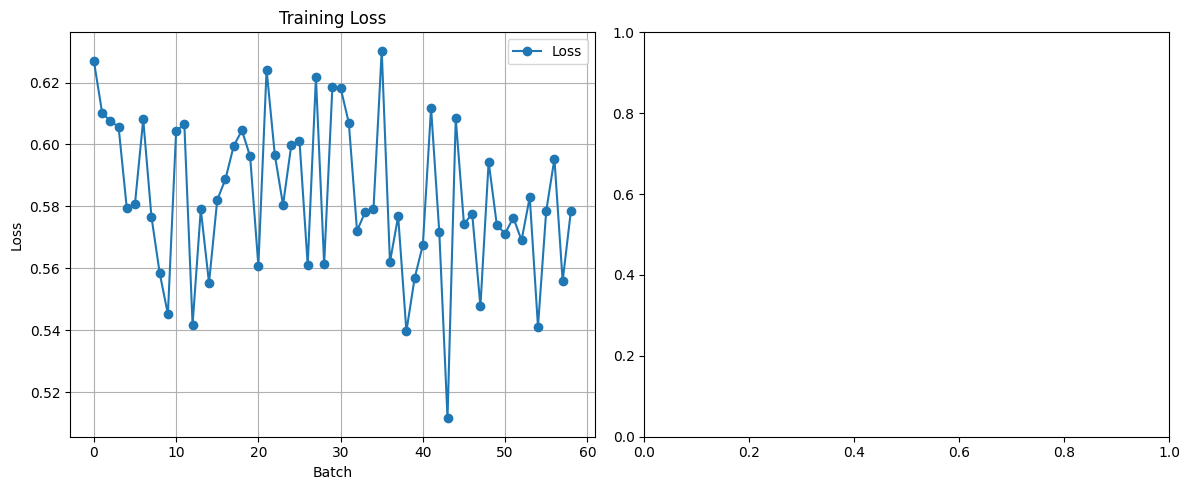

epoch 61: 100%|█████████▉| 371/372 [17:24<00:02,  2.81s/it, epoch :61 , batch =0.997]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,61,"tf.Tensor(0.60052675, shape=(), dtype=float32)","tf.Tensor(0.7971273, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.5303912, shape=(), dtype=float32)","(tf.Tensor(0.9014915, shape=(), dtype=float32)...","tf.Tensor(0.4904602, shape=(), dtype=float32)","(tf.Tensor(0.9481941, shape=(), dtype=float32)...","tf.Tensor(0.89591014, shape=(), dtype=float32)"


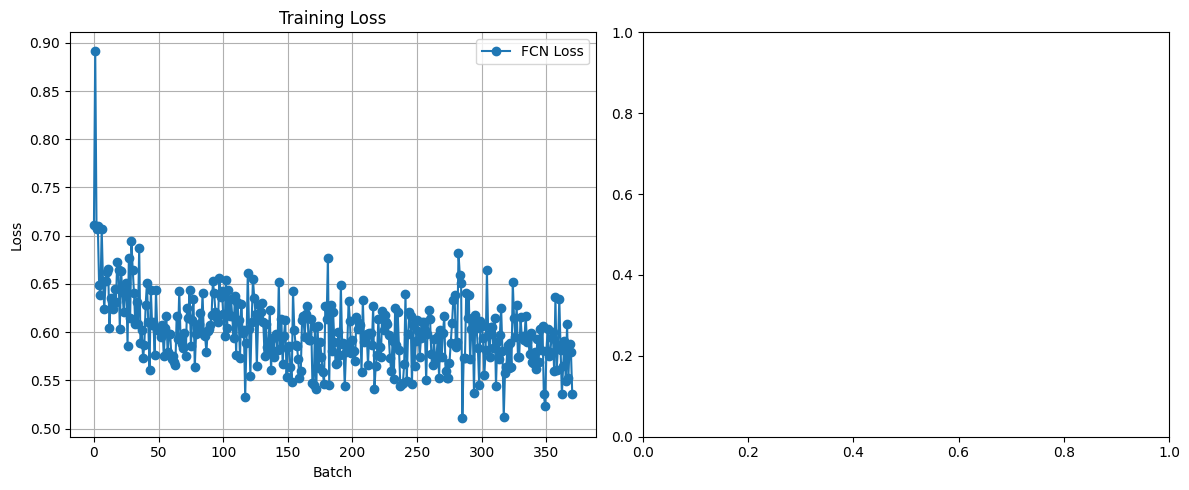


Checkpoint saved for epoch 61 at /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-67 for <Unet name=unet_resnet50, built=True> model
Epoch begins : 62


epoch 62:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 62: 100%|█████████▉| 371/372 [09:13<00:01,  1.49s/it, epoch :62 , batch =0.997]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,62,"tf.Tensor(0.58635116, shape=(), dtype=float32)","tf.Tensor(0.79394984, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.5314911, shape=(), dtype=float32)","(tf.Tensor(0.9016964, shape=(), dtype=float32)...","tf.Tensor(0.49362442, shape=(), dtype=float32)","(tf.Tensor(0.9483074, shape=(), dtype=float32)...","tf.Tensor(0.896247, shape=(), dtype=float32)"


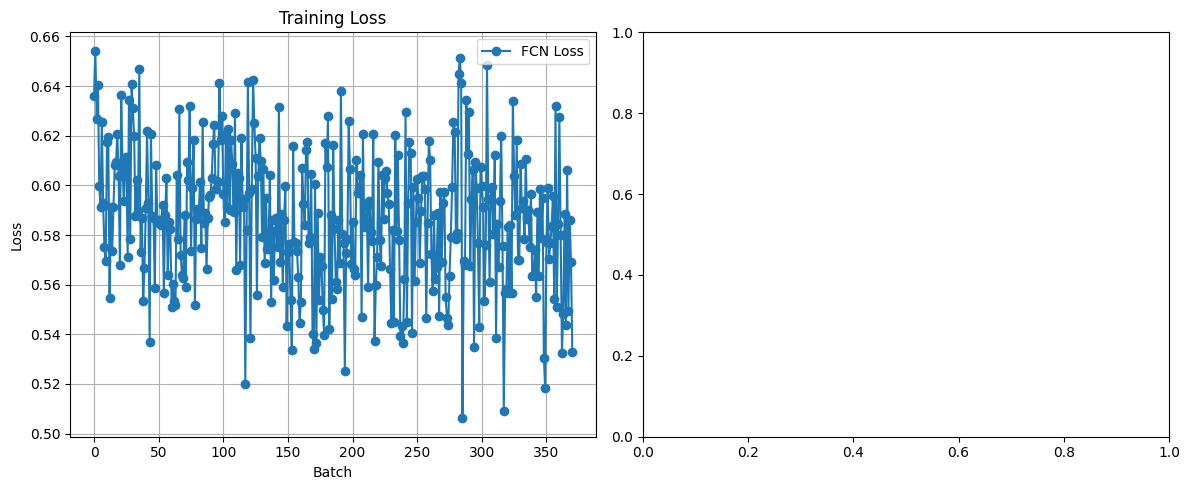


Checkpoint saved for epoch 62 at /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-68 for <Unet name=unet_resnet50, built=True> model
Epoch begins : 63


epoch 63:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 63: 100%|█████████▉| 371/372 [09:11<00:01,  1.49s/it, epoch :63 , batch =0.997]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,63,"tf.Tensor(0.58276445, shape=(), dtype=float32)","tf.Tensor(0.7931549, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.5317151, shape=(), dtype=float32)","(tf.Tensor(0.90158087, shape=(), dtype=float32...","tf.Tensor(0.49746886, shape=(), dtype=float32)","(tf.Tensor(0.94824344, shape=(), dtype=float32...","tf.Tensor(0.8961809, shape=(), dtype=float32)"


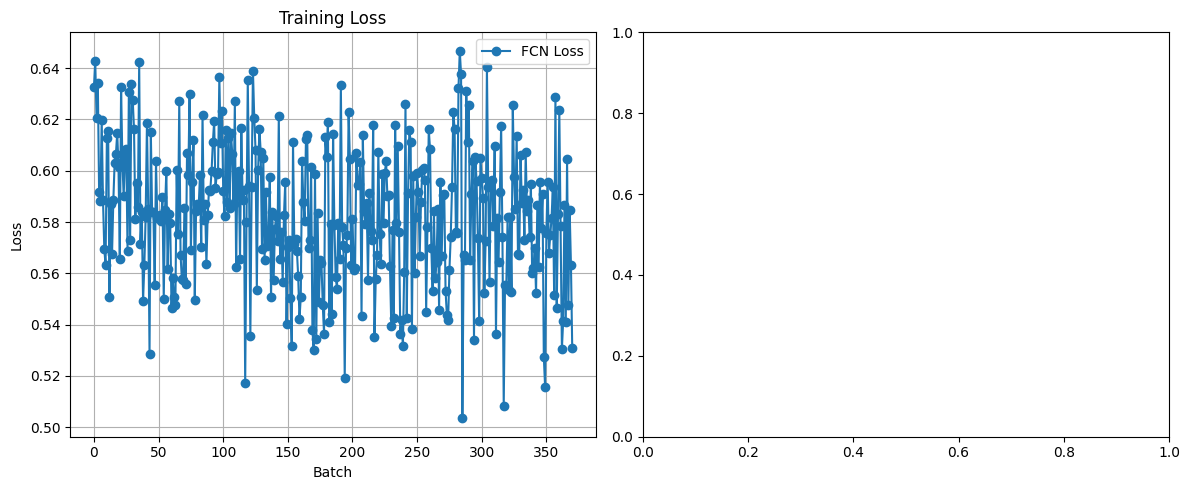


Checkpoint saved for epoch 63 at /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-69 for <Unet name=unet_resnet50, built=True> model
Epoch begins : 64


epoch 64:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 64: 100%|█████████▉| 371/372 [09:09<00:01,  1.48s/it, epoch :64 , batch =0.997]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,64,"tf.Tensor(0.5803717, shape=(), dtype=float32)","tf.Tensor(0.79363805, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.53129774, shape=(), dtype=float32)","(tf.Tensor(0.90135485, shape=(), dtype=float32...","tf.Tensor(0.5003703, shape=(), dtype=float32)","(tf.Tensor(0.9481183, shape=(), dtype=float32)...","tf.Tensor(0.8959335, shape=(), dtype=float32)"


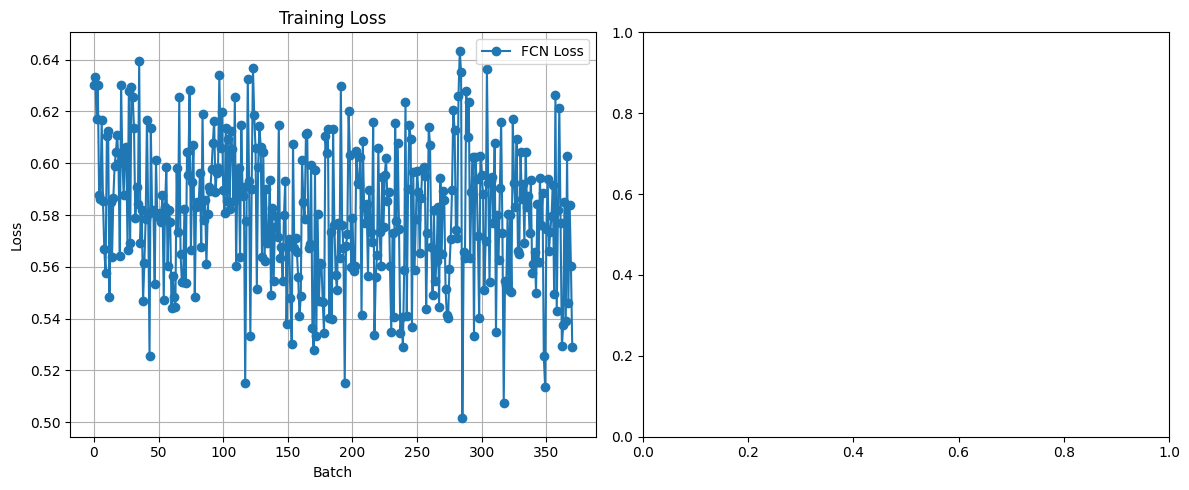


Checkpoint saved for epoch 64 at /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-70 for <Unet name=unet_resnet50, built=True> model
Epoch begins : 65


epoch 65:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 65: 100%|█████████▉| 371/372 [09:11<00:01,  1.49s/it, epoch :65 , batch =0.997]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,65,"tf.Tensor(0.57843095, shape=(), dtype=float32)","tf.Tensor(0.7940654, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.53169936, shape=(), dtype=float32)","(tf.Tensor(0.9013399, shape=(), dtype=float32)...","tf.Tensor(0.5004218, shape=(), dtype=float32)","(tf.Tensor(0.94811016, shape=(), dtype=float32...","tf.Tensor(0.8959279, shape=(), dtype=float32)"


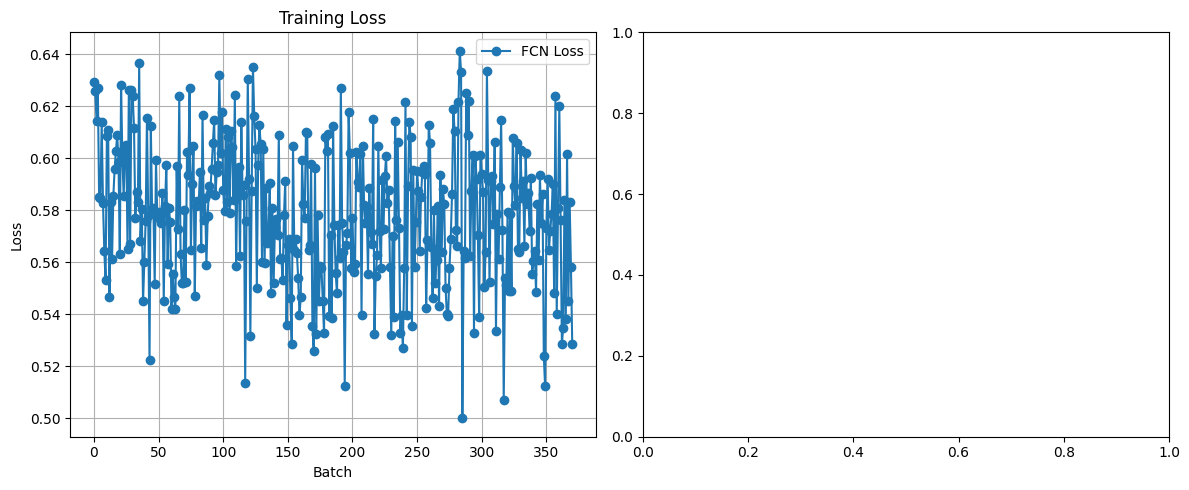


Checkpoint saved for epoch 65 at /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-71 for <Unet name=unet_resnet50, built=True> model
Epoch begins : 66


epoch 66:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 66: 100%|█████████▉| 371/372 [09:03<00:01,  1.46s/it, epoch :66 , batch =0.997]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,66,"tf.Tensor(0.5767336, shape=(), dtype=float32)","tf.Tensor(0.7948865, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.5315729, shape=(), dtype=float32)","(tf.Tensor(0.9009231, shape=(), dtype=float32)...","tf.Tensor(0.503124, shape=(), dtype=float32)","(tf.Tensor(0.9478795, shape=(), dtype=float32)...","tf.Tensor(0.895715, shape=(), dtype=float32)"


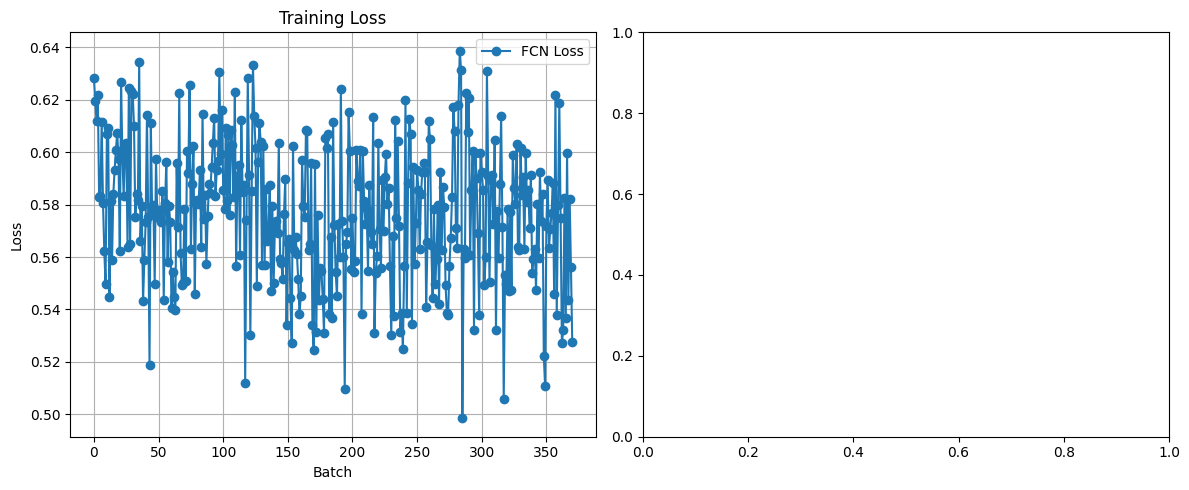


Checkpoint saved for epoch 66 at /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-72 for <Unet name=unet_resnet50, built=True> model
learning rate for model  has been change from : 1.56249996052793e-06 to the new lr : 7.81249980263965e-07 at epoch : 66
Epoch begins : 67


epoch 67:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 67: 100%|█████████▉| 371/372 [09:09<00:01,  1.48s/it, epoch :67 , batch =0.997]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,67,"tf.Tensor(0.5754935, shape=(), dtype=float32)","tf.Tensor(0.7959448, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.53115636, shape=(), dtype=float32)","(tf.Tensor(0.90092975, shape=(), dtype=float32...","tf.Tensor(0.5087246, shape=(), dtype=float32)","(tf.Tensor(0.9478831, shape=(), dtype=float32)...","tf.Tensor(0.8957023, shape=(), dtype=float32)"


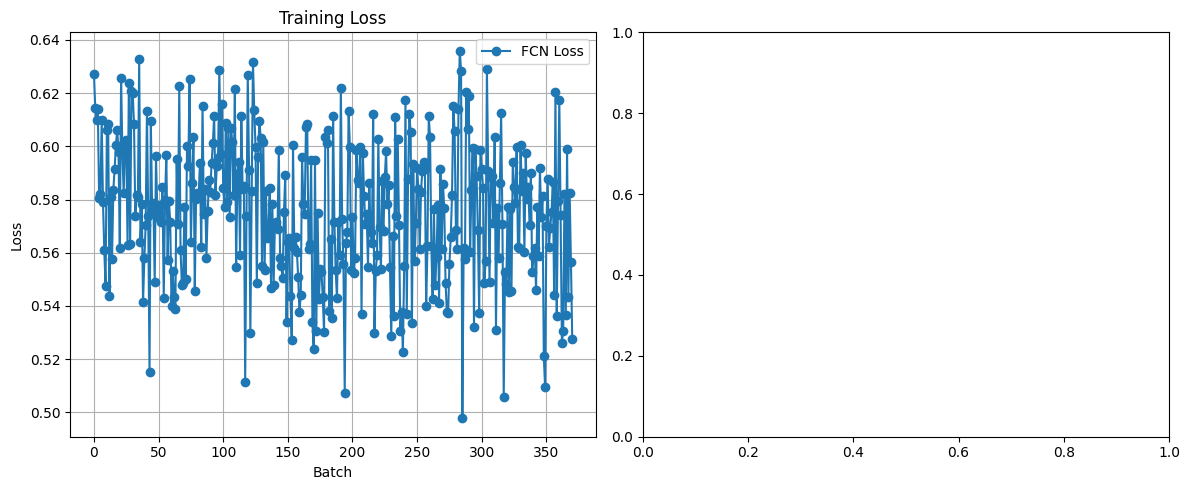


Checkpoint saved for epoch 67 at /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-73 for <Unet name=unet_resnet50, built=True> model
Epoch begins : 68


epoch 68:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 68: 100%|█████████▉| 371/372 [09:10<00:01,  1.48s/it, epoch :68 , batch =0.997]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,68,"tf.Tensor(0.57465273, shape=(), dtype=float32)","tf.Tensor(0.7964333, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.53104955, shape=(), dtype=float32)","(tf.Tensor(0.900773, shape=(), dtype=float32),...","tf.Tensor(0.50593156, shape=(), dtype=float32)","(tf.Tensor(0.94779664, shape=(), dtype=float32...","tf.Tensor(0.89559335, shape=(), dtype=float32)"


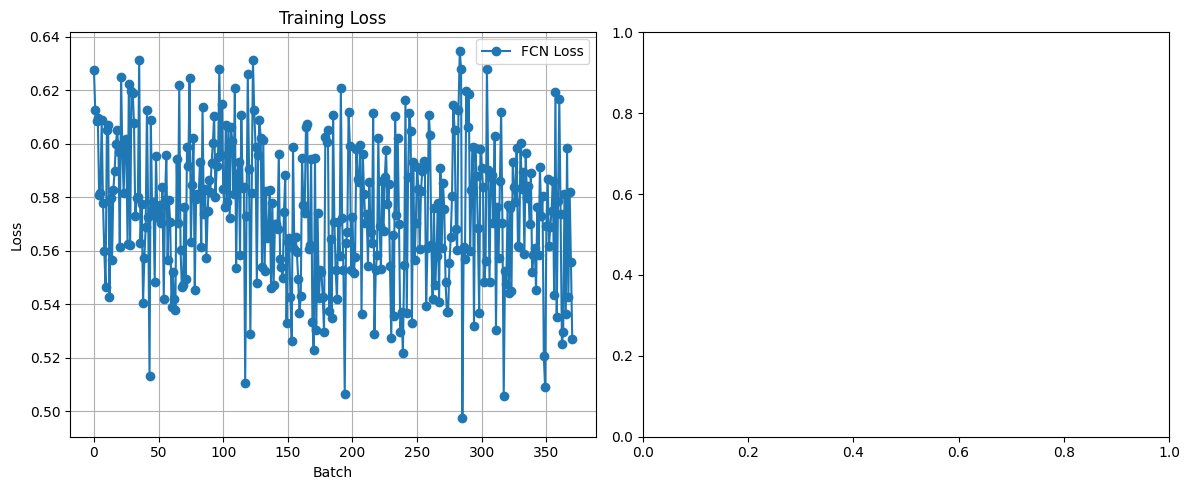


Checkpoint saved for epoch 68 at /content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-74 for <Unet name=unet_resnet50, built=True> model
Epoch begins : 69


epoch 69:   0%|          | 0/372 [00:00<?, ?it/s]

epoch 69:  16%|█▌        | 59/372 [01:37<11:19,  2.17s/it, epoch :69 , batch =0.159]

In [ ]:
with strategy.scope():
  stop_training =False
  start=unet_master_callback.on_train_begin()
  for epoch in range(start , 250 ):
    unet_master_callback.on_epoch_begin(epoch)
    losses = train_unet_for_one_epoch(epoch)
    val_losses = val_unet_for_one_epoch()
    avg_loss = tf.reduce_mean(losses)
    avg_val_loss = tf.reduce_mean(val_losses)
    data = {

                'loss' : avg_loss ,
                'val_loss' : avg_val_loss ,
                'metrics': {
                    'IOUMetric' : unet_IOUMetric.result(),
                    'PerClassIOUMetric' : unet_PerClassIOUMetric.result(),
                    'Dice_Coefficent_matrics' : unet_Dice_Coefficent_matrics.result(),
                    'PerClassDiceCoefficientMatrics' : unet_PerClassDiceCoefficientMatrics.result() ,
                    'Pixel_accurcy_metrics' : unet_Pixel_accurcy_metrics.result(),

                    'IOUMetric_val' : unet_IOUMetric_val.result(),
                    'PerClassIOUMetric_val' : unet_PerClassIOUMetric_val.result(),
                    'Dice_Coefficent_matrics_val' : unet_Dice_Coefficent_matrics_val.result(),
                    'PerClassDiceCoefficientMatrics_val' : unet_PerClassDiceCoefficientMatrics_val.result() ,
                    'Pixel_accurcy_metrics_val' : unet_Pixel_accurcy_metrics_val.result()

            },
        }
    unet_IOUMetric.reset_state()
    unet_IOUMetric_val.reset_state()
    unet_PerClassIOUMetric.reset_state()
    unet_PerClassIOUMetric_val.reset_state()
    unet_Dice_Coefficent_matrics.reset_state()
    unet_Dice_Coefficent_matrics_val.reset_state()
    unet_PerClassDiceCoefficientMatrics.reset_state()
    unet_PerClassDiceCoefficientMatrics_val.reset_state()
    unet_Pixel_accurcy_metrics.reset_state()
    unet_Pixel_accurcy_metrics_val.reset_state()



    stop_training=unet_master_callback.on_epoch_end(epoch=epoch , data= data)
    if stop_training :
      break

new lr : 1.56249996052793e-07

In [ ]:
checkpoint = tf.train.Checkpoint(model=unet)
checkpoint.restore('/content/drive/MyDrive/CityScapes_model_checkpoints_new/unet/ckpt-71').expect_partial()

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from PIL import Image

# Define palette
cityscapes_palette = np.array([
    [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153],
    [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152],
    [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
    [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 0]
], dtype=np.uint8)

# Read and preprocess a single frame
def preprocess_frame(frame):
    frame = cv2.resize(frame, (1280, 640))
    img = tf.keras.applications.resnet50.preprocess_input(frame)
    return np.expand_dims(img, axis=0)

# Predict and get colored mask
def get_colored_mask(prediction):
    mask = np.argmax(prediction, axis=-1)[0].astype(np.uint8)
    colored_mask = cityscapes_palette[mask]
    return colored_mask

# Apply prediction on video
def segment_video(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)

    # Get original video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (1280, 640))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        input_tensor = preprocess_frame(frame)
        prediction = unet(input_tensor)

        colored_mask = get_colored_mask(prediction)

        # Resize to match original frame size if needed
        colored_mask = cv2.resize(colored_mask, (1280, 640), interpolation=cv2.INTER_NEAREST)

        # Write the mask as a frame (optional: overlay on original)
        out.write(colored_mask)

    cap.release()
    out.release()
    print("Segmentation video saved to:", output_video_path)

# Call function
segment_video('/content/4608285-uhd_3840_2160_24fps.mp4', '/content/drive/MyDrive/output_segmentation.mp4')


Segmentation video saved to: /content/drive/MyDrive/output_segmentation.mp4


In [ ]:
from google.colab import files
files.download('/content/output_segmented_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

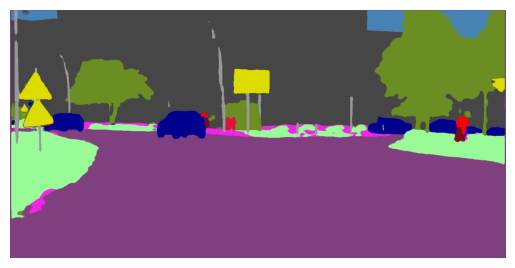

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the CityScapes color palette (for 19 training classes + void)
cityscapes_palette = np.array([
    [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153],
    [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152],
    [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
    [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 0]
], dtype=np.uint8)

# Your existing code
def read_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (640, 1280))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

img = read_img('/content/original.png')
img = np.expand_dims(img, axis=0)
prediction = unet(img)  # Shape: (1, 256, 512, num_classes)
mask = np.argmax(prediction, axis=-1).astype(np.uint8)  # Shape: (1, 256, 512)

# Remove batch dimension
mask = mask[0]  # Shape: (256, 512)

# Map class indices to colors
colored_mask = cityscapes_palette[mask]  # Shape: (256, 512, 3)

# Resize to original dimensions
colored_mask_tensor = tf.convert_to_tensor(colored_mask, dtype=tf.float32)
colored_mask_resized = tf.image.resize(colored_mask_tensor, (640, 1280), method='nearest')
colored_mask_resized = tf.cast(colored_mask_resized, tf.uint8).numpy()

# Display the mask
plt.imshow(colored_mask_resized)
plt.axis('off')
plt.show()

# Save the mask
Image.fromarray(colored_mask_resized).save("/content/drive/MyDrive/colored_mask.png")

In [ ]:
from google.colab import  files
files.download('/content/drive/MyDrive/output_segmentation.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>